In [1]:
import torch

print('before: ', torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print('after', torch.cuda.memory_allocated())

before:  0
after 0


In [2]:
# Just testing my Spatial AE

import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms

from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *


/tmp/ipykernel_18555/551020608.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [3]:
raw_frames = np.load('data/frames_default_2023-10-26-00-20-15.npy')
#f = np.transpose(raw_frames, (0, 3, 1, 2))
print(raw_frames.shape)
print(raw_frames[0:7].shape)
print(np.concatenate(raw_frames[0:7], axis=1).shape)

(5500, 128, 128, 3)
(7, 128, 128, 3)
(128, 896, 3)


In [4]:
torch.manual_seed(321)

model_file = 'model_files/default_env_spatial_ae.pt'

# need to consider if you actually want to transform
transform = transforms.Compose([
     transforms.ToTensor()])

trainset_file = 'data/default_trainset_15000.pt'
testset_file = 'data/default_testset_2713.pt'

#if load_dataset: # notebook kernel likes to die when we build it so load it when possible
#    train_data = TensorDataset(torch.load(trainset_file))
#    test_data = TensorDataset(torch.load(testset_file))
#else:
frames_files = ['data/frames_default_2023-10-26-00-20-15.npy']#, 
                ##'data/frames_default_2023-10-26-01-07-09.npy',
                #'data/frames_default_2023-10-26-16-58-26.npy']
    
raw_frames = np.load(frames_files[0])
print(raw_frames.shape)
for i in range(1, len(frames_files)):
    print(np.load(frames_files[i]).shape)
    f = np.load(frames_files[i])
    raw_frames = np.concatenate((raw_frames, f), axis=0)

train_data = SequentialFrameDataset(raw_frames, transform=transform)#[:15000])#, transform=transform)
test_data = SequentialFrameDataset(raw_frames, transform=transform)#[15001:])#, transform=transform)

batch_size = 32
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

(5500, 128, 128, 3)


In [5]:
print('before: ', torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print('after', torch.cuda.memory_allocated())

before:  0
after 0


torch.Size([3, 128, 896])
(3, 128, 896)


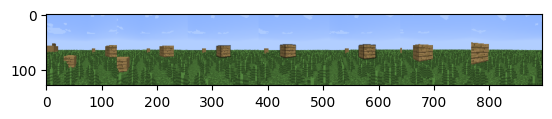

(3, 128, 128)


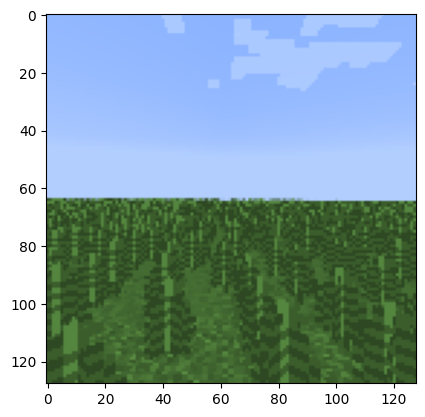

In [19]:
# Take a look at the sequence of images
import torchvision

def imshow(img, savefile=None):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if savefile:
        plt.savefig(savefile)
    plt.show()

seq, preds = next(iter(train_loader))
print(seq[0].shape)

imshow(seq[0], 'figures/example-sequence-default-env.png')
imshow(preds[0], 'figures/example-pred-default-env.png')

In [16]:
print('before: ', torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print('after', torch.cuda.memory_allocated())

before:  6088681472
after 6088681472


In [8]:
model = SpatialAE()
model.to(device)
print(len(train_loader))

num_epochs = 30 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


22


In [9]:
print('before: ', torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print('after', torch.cuda.memory_allocated())

before:  172606464
after 172606464


In [10]:
train_losses_file = 'logs/spatial-ae-default-ep30-train.txt'
test_losses_file = 'logs/spatial-ae-cifar10-ep30-test.txt'

train_losses = []
test_losses = []
t = trange(num_epochs)

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
-------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacty of 5.93 GiB of which 13.00 MiB is free. Including non-PyTorch memory, this process has 5.77 GiB memory in use. Of the allocated memory 5.67 GiB is allocated by PyTorch, and 21.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
print('before: ', torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print('after', torch.cuda.memory_allocated())

before:  6088681472
after 6088681472
